In [79]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
# Load the dataset
iris_data = pd.read_csv('iris.csv')

In [81]:
# Preprocessing the data
X = iris_data.drop('species', axis=1).values
y = iris_data['species'].values

# Encode the labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [82]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [84]:
# Define the neural network model
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # input layer with 4 features, hidden layer with 10 neurons
        self.fc2 = nn.Linear(64, 32)  # hidden layer with 8 neurons
        self.fc3 = nn.Linear(32, 3)   # output layer with 3 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [85]:
# Initialize the model
model = IrisNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [86]:
# Train the model
def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_output = model(X_test)
            val_loss = criterion(val_output, y_test)
            val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    return train_losses, val_losses

In [87]:
# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred_probs = model(X_test)
        _, y_pred = torch.max(y_pred_probs, 1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    return y_pred, y_pred_probs

In [88]:
# Train the model
train_losses, val_losses = train_model(model, X_train, y_train, X_test, y_test)

Epoch [0/100], Train Loss: 1.1466, Validation Loss: 1.1374
Epoch [10/100], Train Loss: 1.0014, Validation Loss: 0.9871
Epoch [20/100], Train Loss: 0.8779, Validation Loss: 0.8486
Epoch [30/100], Train Loss: 0.7496, Validation Loss: 0.7068
Epoch [40/100], Train Loss: 0.6262, Validation Loss: 0.5751
Epoch [50/100], Train Loss: 0.5240, Validation Loss: 0.4687
Epoch [60/100], Train Loss: 0.4427, Validation Loss: 0.3862
Epoch [70/100], Train Loss: 0.3765, Validation Loss: 0.3207
Epoch [80/100], Train Loss: 0.3217, Validation Loss: 0.2672
Epoch [90/100], Train Loss: 0.2757, Validation Loss: 0.2214


In [89]:
# Evaluate the trained model
y_pred, y_pred_probs = evaluate_model(model, X_test, y_test)

Accuracy: 100.00%
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



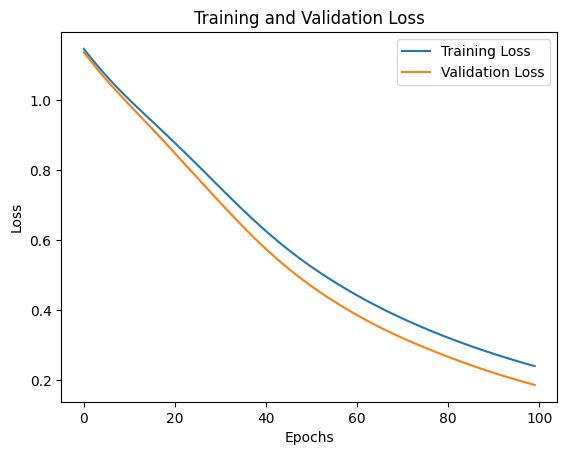

In [90]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
# Plot ROC-AUC curves for each class
def plot_roc_auc(y_test, y_pred_probs):
    y_test_np = y_test.numpy()
    y_pred_np = y_pred_probs.numpy()
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve((y_test_np == i).astype(int), y_pred_np[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

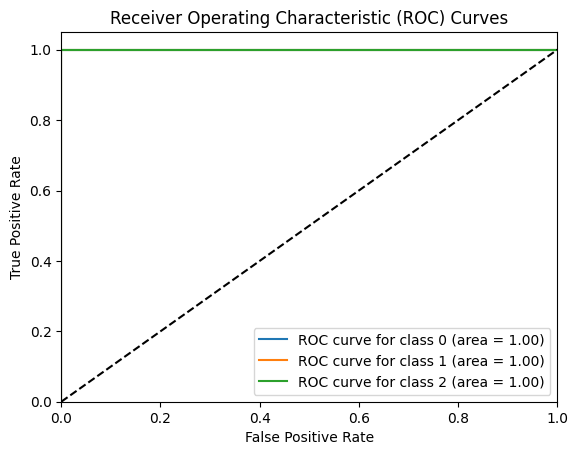

In [92]:
plot_roc_auc(y_test, y_pred_probs)